## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

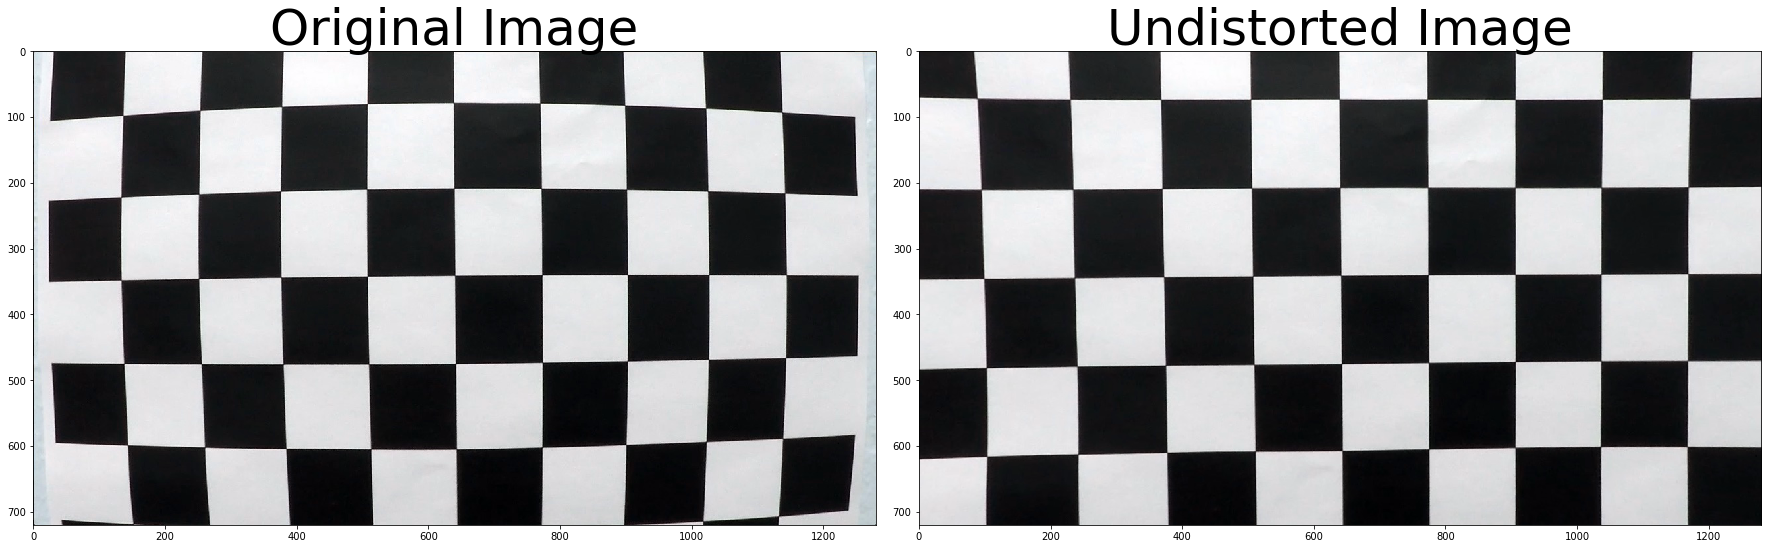

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # cv2.imshow('img',img)
        # cv2.waitKey(500)
                    
#cv2.destroyAllWindows()

image_name = './camera_cal/calibration1.jpg'
img = cv2.imread(image_name)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Apply a distortion correction to raw images.

In [2]:
def undistort_image(mtx, dist, image):
    undist_image = cv2.undistort(image, mtx, dist, None, mtx)
    return undist_image

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [3]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    abs_sobel_8 = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output = np.zeros_like(abs_sobel_8)
    binary_output[(abs_sobel_8 >= thresh[0]) & (abs_sobel_8 <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobelxy)
    binary_output[(scaled_sobelxy >= mag_thresh[0]) & (scaled_sobelxy <= mag_thresh[1])]=1
    # Return this mask as your binary_output image
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) 
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_direction = np.arctan2(abs_sobely, abs_sobelx) 
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(grad_direction)
    binary_output[(grad_direction >= thresh[0]) & (grad_direction <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output


def transformations(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Sobel x
    sxbinary = abs_sobel_thresh(gray, 'x', 5, (20, 100))
    sybinary = abs_sobel_thresh(gray, 'y', 5, (20, 100))
    sxybinary = mag_thresh(gray, 9, (20, 100))
    sdirbinary = dir_threshold(gray, 15, (0.7, 1.3))
    
    # Threshold color channel
    s_thresh_min = 120
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    l_thresh_min = 40
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) & (l_binary == 1) | (sxbinary == 1) & (sybinary == 1) | (sxybinary == 1) & (sdirbinary == 1)] = 1
    return combined_binary



## Apply a perspective transform to rectify binary image ("birds-eye view").

In [4]:
def perspective_transform(image):
    img_size = (image.shape[1],image.shape[0])
    #4 source points src = np.float32([[,],[,],[,],[,]])
    imshape = image.shape
    #src = np.array([(imshape[1]/5, imshape[0]*23/24), (imshape[1]/2 - 30, 3 * imshape[0]/5), (imshape[1]/2 + 30,2 * imshape[0]/5), (imshape[1]-imshape[1]/6, imshape[0]*23/24)], dtype=np.float32)
    #print(vertices)
    src = np.float32([[250,690], [580,460], [710,460], [1070,690]])
    #print(src)
    # 4 destination points
    #dst = np.array([(imshape[1]/5, imshape[0]*11/12), (imshape[1]/5, 0), (imshape[1]-imshape[1]/8,0), (imshape[1]-imshape[1]/8, imshape[0]*11/12)], dtype=np.float32)
    #print(dst)
    dst = np.float32([[250,720], [250,0], [1030,0],[1030,720]])
    # d)the transform matrix and inv transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    binary_warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return Minv,binary_warped

## Detect lane pixels and fit to find the lane boundary.

In [5]:
def lane_boundary(image):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[int(image.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((image, image, image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, left_lane_inds, right_lane_inds

## Look-Ahead Filter

In [6]:
def polyfit_using_prev_fit(image, left_fit_prev, right_fit_prev):
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        
    return left_fit, right_fit, left_lane_inds, right_lane_inds

## Warp the detected lane boundaries back onto the original image.

In [7]:
def draw_lane_boundaries(perspective_image, original_image, left_fit, right_fit, left_lane_inds, right_lane_inds, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(perspective_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
     # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0])) 
    
    # Determine the curvature of the lane and vehicle position with respect to center.
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    nonzero = perspective_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    middle = (left_fitx[-1] + right_fitx[-1])//2
    veh_pos = image.shape[1]//2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    dx = (veh_pos - middle)*xm_per_pix # Positive on right, Negative on left
    
    return newwarp, left_curverad, right_curverad, dx

## Lane class for keeping history

In [8]:

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit!
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

## Draw advance lane line pipeline

In [9]:
def advance_lane_lines(image):
    undist_image = undistort_image(mtx, dist, image)
    binary_image = transformations(undist_image)
    Minv, binary_wraped_image = perspective_transform(binary_image)
    if not l_line.detected or not r_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds = lane_boundary(binary_wraped_image)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit_using_prev_fit(binary_wraped_image, l_line.best_fit, r_line.best_fit)
        
    l_line.add_fit(left_fit, left_lane_inds)
    r_line.add_fit(right_fit, right_lane_inds)

    if l_line.best_fit is not None and r_line.best_fit is not None:
        lane_lines_image, left_curverad, right_curverad, dx = draw_lane_boundaries(binary_wraped_image, undist_image, l_line.best_fit, r_line.best_fit, left_lane_inds, right_lane_inds, Minv)
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, lane_lines_image, 0.3, 0)
        cv2.putText(result,'Radius of left Curvature: %.2fm' % left_curverad, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(result,'Radius of right Curvature: %.2fm' % right_curverad, (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(result,'Vehicle position : %.2f m %s of center'%(abs(dx), 'left' if dx < 0 else 'right'), (20,120), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    else:
        result = undist_image
    return result

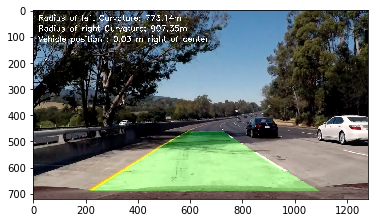

In [23]:
l_line = Line()
r_line = Line()
image = cv2.imread('./test_images/test5.jpg')
    
output_image = advance_lane_lines(image)
plt.imshow(cv2.cvtColor(output_image,cv2.COLOR_BGR2RGB))
#plt.imshow(output_image)

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

l_line = Line()
r_line = Line()
output = './project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
clip = clip1.fl_image(advance_lane_lines) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [06:11<00:00,  3.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 6min 29s, sys: 1min 13s, total: 7min 42s
Wall time: 6min 12s
